In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn import preprocessing
import torch
from torch.utils.data import DataLoader
import copy
from torch import nn
%matplotlib inline
import matplotlib.pyplot as plt
from dnaDataloader import expermentDataloader
from dnaDataloader import addData
from dnaModelUtil import printStats
from scipy import stats as st
from datetime import datetime

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
batch_size = 100
device

device(type='cuda', index=1)

#### large dataset
----

In [13]:
datasetLarge = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/large_dataset/allData/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/large_dataset/allData/", 
)
print(f"datasetLarge:{len(datasetLarge)}")

datasetLarge:3862


In [14]:
rawData = [datasetLarge[i] for i in list(range(len(datasetLarge)))]
print(f"input: {rawData[0][0]}")
print(f"output: {rawData[0][1]}")

input: [0 0 0 ... 0 0 0]
output: [50]


In [15]:
# def switchToDurration(expermentFrames):
#     lastOne = 0
#     for i in range(len(expermentFrames)):
#         if expermentFrames[i]:
#             expermentFrames[i] = i - lastOne if lastOne != 0 else 0
#             lastOne = i
#     return expermentFrames

# for i in rawData:
#     i = (switchToDurration(i[0]), i[1])
# print(f"input: {rawData[0][0]}")
# print(f"output: {rawData[0][1]}")

featIn 12000


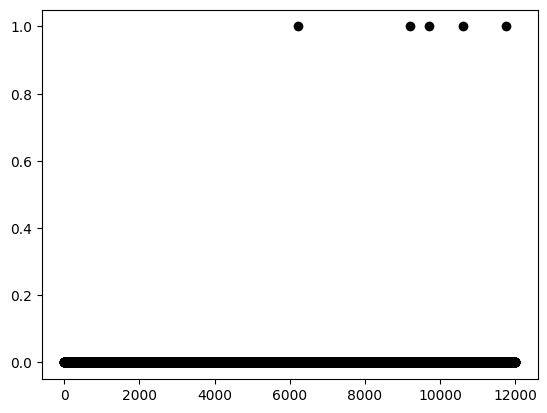

In [16]:
plt.plot(list(range(len(rawData[0][0]))), rawData[0][0], 'o', color='black')
featIn = len(rawData[0][0])
print(f"featIn {featIn}")

In [17]:
trainValidData = []
testData = []
addData(trainValidData, testData, rawData, rhsSize=int(len(rawData)*0.90))


np.random.shuffle(trainValidData)
trainData = []
validData = []
addData(trainData, validData, trainValidData, rhsSize=int(len(trainValidData)*0.5))

trainDataset = DataLoader(trainData, batch_size=batch_size, shuffle=True, num_workers=16)
testDataset = DataLoader(testData, batch_size=len(testData), shuffle=True, num_workers=16)
validDataset = DataLoader(validData, batch_size=batch_size, shuffle=True, num_workers=16)
print(f"Training dataset size: {len(trainData)}")
print(f"Testing dataset size: {len(testData)}")
print(f"Valid dataset size: {len(validData)}")
print(f"Total: {len(trainData) + len(validData) + len(testData)}")
print(f"number train batches:{len(trainDataset)}")
print(f"number test batches:{len(testDataset)}")
print(f"number valid batches:{len(validDataset)}")

Training dataset size: 194
Testing dataset size: 3475
Valid dataset size: 193
Total: 3862
number train batches:2
number test batches:1
number valid batches:2


In [18]:
device

device(type='cuda', index=1)

In [19]:
model = nn.Sequential(
          nn.Linear(featIn,700),
          nn.ReLU(),
          nn.Dropout(p=0.2),
          nn.Linear(700,700),
          nn.ReLU(),
          nn.Dropout(p=0.2),
          nn.Linear(700,700),
          nn.ReLU(),
          nn.Linear(700,1),
        )
model.to(device)
MSE = nn.MSELoss(reduction = 'sum')
adam = torch.optim.Adam(model.parameters(),lr=0.000001,weight_decay=1e-5)

em = 20
epochs = 10000
losses = []
accs = []
print("training...")
for e in range(epochs): 
    avgLossTrain = []
    currentAccTrain = []
    model.train()
    for i, (inputs, targets) in enumerate(trainDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        loss = MSE(outputs, targets)
        avgLossTrain.append(float(loss.item()))
        adam.zero_grad()
        loss.backward()
        adam.step()
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.item()
        currentAccTrain.append(float(totalCorrect/len(targets)))
        
    avgLoss = []
    currentAcc = []
    model.eval()
    for i, (inputs, targets) in enumerate(validDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        loss = MSE(outputs, targets)
        outputPlot = outputs.clone().detach().cpu().numpy()
        targetsPlot = targets.clone().detach().cpu().numpy()
        avgLoss.append(float(loss.clone().detach().cpu().numpy()))
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.clone().detach().cpu().numpy()
        currentAcc.append(float(totalCorrect/len(targets)))
        print(f"\
        epoch: {e}/{epochs}\t \
        Train Loss:{'%.4f' % (np.sum(avgLossTrain)/len(avgLossTrain))} Valid Loss:{'%.4f' % (np.sum(avgLoss)/len(avgLoss))}\t \
        Train accuracy:{'%.4f' % (np.sum(currentAccTrain)/len(currentAccTrain))} Valid accuracy:{'%.4f' % (np.sum(currentAcc)/len(currentAcc))} \
        ",end="\x1b\r")
    accs.append(float(np.sum(currentAcc)/len(currentAcc)))
    losses.append(float(np.sum(avgLoss)/len(avgLoss)))

training...


KeyboardInterrupt: 

In [ ]:
defultePlotSize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [20, 5]
plt.subplot(1, 2, 1)
plt.title('accuracy vs epochs')
plt.plot(list(range(len(accs[:]))), accs[:], '-', color='black', )
plt.subplot(1, 2, 2)
plt.title('losse vs epochs')
plt.plot(list(range(len(losses)))[:], losses[:], '-', color='black')
plt.rcParams['figure.figsize'] = defultePlotSize
epochs*len(validDataset)

In [ ]:
title = "working with large dataset small training set nnLinearfeatIn-700-nnReLU-nnDropoutp-02-nnLinear700-nnReLU-nnDropoutp-02-nnLinear700-nnReLU-nnLinear700-1"
dt_string = datetime.now().strftime("%d.%m.%Y_%H-%M-%S-%f")
modelPath = f"./Models/{title.replace(' ', '_')}_{dt_string}.pt"
torch.save(model.state_dict(),modelPath)
print(f"saved to {modelPath}")

## eval
----

In [ ]:
em =40
epochs = 50
accs = []
model.eval()
print("test...")
for e in range(epochs): 
    avgLoss = []
    currentAcc = []
    for i, (inputs, targets) in enumerate(testDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        outputPlot = outputs.clone().detach().cpu().numpy()
        targetsPlot = targets.clone().detach().cpu().numpy()
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.clone().detach().cpu().numpy()
        currentAcc.append(float(totalCorrect/len(targets)))
        accs.append(float(totalCorrect/len(targets)))

print(f"\
    accuracy:{np.sum(accs)/len(accs)} \
    ",end="\x1b\r")

In [ ]:
defultePlotSize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(list(range(len(outputPlot))), outputPlot, 'o', color='black', label="predicted")
plt.plot(list(range(len(targetsPlot))), targetsPlot, 'o', color='green', label="true" )
plt.xlabel('test case')
plt.ylabel('number of reactions')
plt.title('Large dataset')
plt.legend(loc='upper right')
plt.rcParams['figure.figsize'] = defultePlotSize
diffs = []
for i in range(len(outputPlot)):
    diffs.append(abs(outputPlot[i] - targetsPlot[i]))
printStats(diffs)

#### eval on old data
----

In [ ]:
datasetLoaderlow = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/low/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/low", 
)
datasetLoadermedium = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/medium/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/medium", 
    # startIndex=0, endIndex=60
)
datasetLoaderHigh = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/high/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/data/seperatedData/high", 
    # startIndex=0, endIndex=-1
)



rawData = [datasetLoaderlow[i] for i in list(range(len(datasetLoaderlow)))]
rawData = rawData + [datasetLoadermedium[i] for i in list(range(len(datasetLoadermedium)))]
rawData = rawData + [datasetLoaderHigh[i] for i in list(range(len(datasetLoaderHigh)))]
# rawData = [(switchToDurration(rawData[i][0]), rawData[i][1]) for i in list(range(len(rawData)))]
rawData = [[k,v] for k,v in rawData]
print(f"datasetlow:{len(datasetLoaderlow)}")
print(f"datasetmedium:{len(datasetLoadermedium)}")
print(f"datasetHigh:{len(datasetLoaderHigh)}")
print(f"Total: {len(datasetLoaderlow) + len(datasetLoadermedium) + len(datasetLoaderHigh)}")

In [ ]:
oldDataset = DataLoader(rawData, batch_size=len(rawData), shuffle=True)

In [ ]:
em =40
epochs = 50
accs = []
model.eval()
print("test...")
for e in range(epochs): 
    avgLoss = []
    currentAcc = []
    for i, (inputs, targets) in enumerate(oldDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        outputPlot = outputs.clone().detach().cpu().numpy()
        targetsPlot = targets.clone().detach().cpu().numpy()
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.clone().detach().cpu().numpy()
        currentAcc.append(float(totalCorrect/len(targets)))
        accs.append(float(totalCorrect/len(targets)))

print(f"\
    accuracy:{np.sum(accs)/len(accs)} \
    ",end="\x1b\r")

In [ ]:
defultePlotSize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(list(range(len(outputPlot))), outputPlot, 'o', color='black', label="predicted")
plt.plot(list(range(len(targetsPlot))), targetsPlot, 'o', color='green', label="true" )
plt.xlabel('test case')
plt.ylabel('number of reactions')
plt.title('Large dataset')
plt.legend(loc='upper right')
plt.rcParams['figure.figsize'] = defultePlotSize
diffs = []
for i in range(len(outputPlot)):
    diffs.append(outputPlot[i] - targetsPlot[i])
printStats(diffs)